# Proceso creativo

In [598]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_leer = "./resources/examples/img4.jpg"
# Carga la imagen
imgColor = cv2.imread(img_leer)

# Carga la imagen en escala de grises
imagen = cv2.imread(img_leer, cv2.IMREAD_GRAYSCALE)  

In [579]:
# Binarizacion

umbral_global = 150


# Aplica la binarización en toda la imagen
_, imagen_binarizada = cv2.threshold(imagen, umbral_global, 255, cv2.THRESH_BINARY)

##cv2.imshow("Imagen Binarizada con Componentes Conectados", imagen_binarizada)
# Convierte la imagen binarizada a escala de grises

# Aplica la detección de componentes conectados en la imagen binarizada en escala de grises
_, labels, stats, centroids = cv2.connectedComponentsWithStats(imagen_binarizada)


##Si descomento esto puedo ver todos los componentes detectados antes de filtrarlos
""" for i in range(1, len(stats)):
    x, y, w, h, area = stats[i]
    cv2.rectangle(imgColor, (x, y), (x + w, y + h), (0, 255, 0), 2)


cv2.imshow("Imagen Binarizada con Componentes Conectados", imgColor)
 """

' for i in range(1, len(stats)):\n    x, y, w, h, area = stats[i]\n    cv2.rectangle(imgColor, (x, y), (x + w, y + h), (0, 255, 0), 2)\n\n\ncv2.imshow("Imagen Binarizada con Componentes Conectados", imgColor)\n '

In [580]:
area_total_imagen = imagen_binarizada.size
for label in range(1, len(stats)):
    ancho = stats[label, cv2.CC_STAT_WIDTH]
    alto = stats[label, cv2.CC_STAT_HEIGHT]
    area_componente = stats[label, cv2.CC_STAT_AREA]

    relacion_aspecto = ancho / alto if ancho != 0 else 0
    relacion_area = area_total_imagen / area_componente
    if not (2.8 < relacion_aspecto < 5):
        labels[
            labels == label
        ] = 0  # Eliminar componente basado en la relación de aspecto
        stats[label] = 0  # Eliminar las estadísticas del componente

    if not (23 < relacion_area < 300):
        labels[labels == label] = 0  # Eliminar componente basado en la relación de área
        stats[label] = 0  # Eliminar las estadísticas del componente


# Convertir la matriz labels a un tipo de datos compatible
labels = np.uint8(labels)

# Remover los componentes eliminados de labels y stats
_, new_labels, new_stats, _ = cv2.connectedComponentsWithStats(labels)

# AQUI IRIA EL NUEVO FILTRO


def filtro_cambio_color_en_proporciones(imagen_binaria, proporciones):
    total_transiciones = 0

    for prop in proporciones:
        # Extraer la fila específica
        fila_a_analizar = imagen_binaria[int(imagen_binaria.shape[0] * prop), :]

        # Calcular las diferencias en la fila
        diferencias = np.abs(np.diff(fila_a_analizar))

        # Sumar las diferencias en la fila
        total_transiciones += np.sum(diferencias)

    return total_transiciones

In [581]:
proporciones_a_analizar = [1 / 4, 1 / 2, 3 / 4]

# Rango de cantidad de diferencias permitidas
rango_cantidad_diferencias = (5000, 10000)

# Nuevos labels y stats que almacenarán solo los componentes que pasan el nuevo filtro
nuevos_labels = np.zeros_like(labels)
nuevos_stats = []
indices_validos = []

In [582]:
# Iterar sobre las estadísticas de los nuevos componentes
for i in range(1, len(new_stats)):
    x, y, w, h, area = new_stats[i]

    # Reiniciar el total de transiciones para cada objeto
    total_transiciones = 0

    # Extraer la región de interés (ROI) de la imagen binarizada
    roi_a_analizar = imagen_binarizada[y : y + h, x : x + w]

    # Aplicar el filtro en las proporciones específicas
    total_transiciones = filtro_cambio_color_en_proporciones(
        roi_a_analizar, proporciones_a_analizar
    )
    print(total_transiciones)

    # Verificar si la suma total de transiciones está dentro del rango
    if not (
        rango_cantidad_diferencias[0]
        <= total_transiciones
        <= rango_cantidad_diferencias[1]
    ):
        # Imprimir la cantidad total de transiciones para cada objeto
        print(new_labels)

        print(f"Objeto {i}: Total de transiciones = {total_transiciones}")

        new_labels[
            new_labels == i
        ] = 0  # Eliminar componente basado en la relación de aspecto
        new_stats[i] = 0  # Eliminar las estadísticas del componente

7421.0


In [583]:
# Convertir la matriz nuevos_labels a un tipo de datos compatible
new_labels = np.uint8(new_labels)

# Remover el componente 0 (fondo) de los nuevos labels y stats
nuevos_labels, _, nuevos_stats, _ = cv2.connectedComponentsWithStats(new_labels)

# Después de la sección donde se aplica el filtro
print("Número de objetos válidos:", len(nuevos_stats))


# Dibuja rectángulos alrededor de los componentes conectados en la imagen original
#for i in range(1, len(nuevos_stats)):
#    x, y, w, h, area = nuevos_stats[i]
#    cv2.rectangle(imgColor, (x, y), (x + w, y + h), (0, 255, 0), 2)

Número de objetos válidos: 2


(Text(0.5, 1.0, 'Recorte de patente'), ([], []), ([], []))

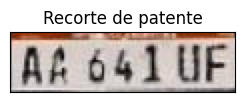

In [584]:
patente = imgColor[
    nuevos_stats[1][1] :
    nuevos_stats[1][1] + nuevos_stats[1][3],
    nuevos_stats[1][0]: 
    nuevos_stats[1][0] + nuevos_stats[1][2]
    ]
plt.subplot(1, 2, 1), plt.imshow(patente, cmap='gray')
plt.title('Recorte de patente'), plt.xticks([]), plt.yticks([])

Text(0, 0.5, 'Frecuencia')

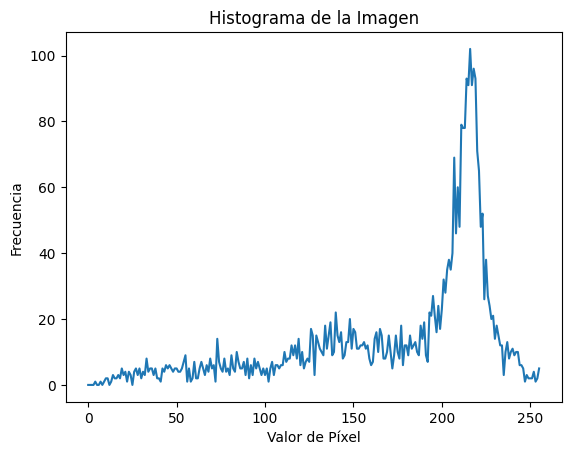

In [585]:
# Muestra el histograma usando Matplotlib

histograma = cv2.calcHist([patente], [0], None, [256], [0, 256])

plt.plot(histograma)
plt.title('Histograma de la Imagen')
plt.xlabel('Valor de Píxel')
plt.ylabel('Frecuencia')

In [586]:
# conviene binarizar ..
patente_grises = cv2.cvtColor(patente, cv2.COLOR_RGB2GRAY)

_, patente_binarizada = cv2.threshold(patente_grises, 150, 255, cv2.THRESH_BINARY)

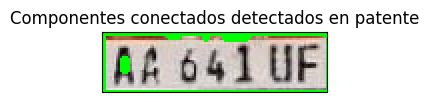

In [587]:
_, labels, stats, centroids = cv2.connectedComponentsWithStats(patente_binarizada)
patente_copia = patente.copy()

for i in range(1, len(stats)):
    x, y, w, h, area = stats[i]
    cv2.rectangle(patente_copia, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Muestra la imagen original y la imagen con componentes coloreados
plt.subplot(1, 2, 1), plt.imshow(patente_binarizada)
plt.title('Patente Binaria'), plt.xticks([]), plt.yticks([])

plt.subplot(1, 2, 1), plt.imshow(patente_copia)
plt.title('Componentes conectados detectados en patente'), plt.xticks([]), plt.yticks([])

plt.show()

In [588]:
altura, ancho = patente_binarizada.shape[:2]
THRESHOLD = 150

In [589]:
# Para trabajar mas comodos, recortemos las lineas que se ven en la parte superior e inferior
filas_a_eliminar = []
for i in range(altura):
    suma = 0
    for j in range(ancho): 
        suma = suma + patente_binarizada[i][j]
    if (suma/ancho) <  THRESHOLD: 
        filas_a_eliminar.append(i)

print(f"Filas a eliminar: {filas_a_eliminar}")

Filas a eliminar: [0, 1, 2, 3, 29]


In [590]:
patente = np.delete(patente, filas_a_eliminar, 0)

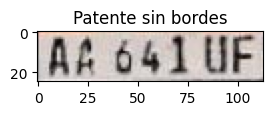

In [601]:
plt.subplot(1, 2, 1), plt.imshow(patente)
plt.title('Patente sin bordes')

Area max: 565.0 - Area min: 54.67741935483871
Area recorte 2129
Area recorte 24
Area recorte 125
Area recorte 79
Area recorte 82
Area recorte 126
Area recorte 92
Area recorte 64
Area recorte 75
Area recorte 5
Area recorte 3
Area recorte 21


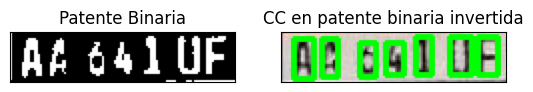

In [592]:
# Categorizemos los espacios entre las letras
# AA 111 AA 
# AA [espacio tipo 1] 111 A[espacio tipo 0]A 

patente_grises = cv2.cvtColor(patente, cv2.COLOR_RGB2GRAY)

_, patente_binarizada = cv2.threshold(patente_grises, 150, 255, cv2.THRESH_BINARY)

_, labels, stats, centroids = cv2.connectedComponentsWithStats(~patente_binarizada)
patente_copia = patente.copy()

stats_letras = []



area_max = (altura*ancho)/6
area_min = (ancho*altura)/62

print(f"Area max: {area_max} - Area min: {area_min}")

for i in range(0, len(stats)):
    x, y, w, h, area = stats[i]
    print(f"Area recorte {area}")
    if area_max > area > area_min:
        stats_letras.append(stats[i])
        cv2.rectangle(patente_copia, (x, y), (x + w, y + h), (0, 255, 0), 2)


# Muestra la imagen original y la imagen con componentes coloreados
plt.subplot(1, 2, 1)
plt.imshow(~patente_binarizada, cmap='gray')
plt.title('Patente Binaria')
plt.xticks([]), plt.yticks([])

plt.subplot(1, 2, 2)  # Cambiado a 2 para que sea el segundo subplot
plt.imshow(patente_copia, cmap='gray')
plt.title('CC en patente binaria invertida')
plt.xticks([]), plt.yticks([])

plt.show()


In [593]:
print(len(stats_letras))

7


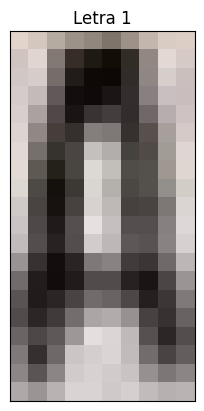

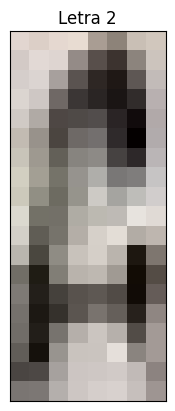

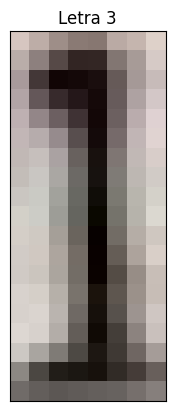

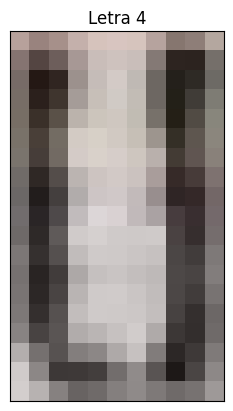

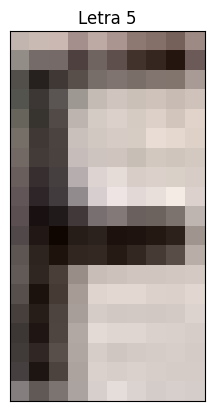

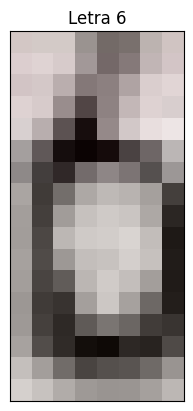

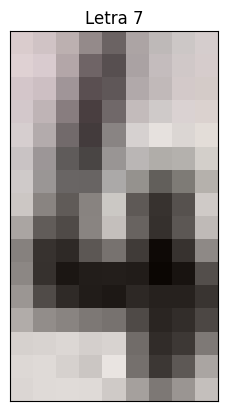

In [596]:
## Recortamos y mostramos las letras

def recortar_imagen(img, selec):
    recorte = img[
    selec[1] :
    selec[1] + selec[3],
    selec[0]: 
    selec[0] + selec[2]
    ].copy()
    return recorte.copy()

for i in range(len(stats_letras)):
    letra = recortar_imagen(patente, stats_letras[i])
    plt.subplot(1, 2, 1)  # Cambiado a 2 para que sea el segundo subplot
    plt.imshow(letra, cmap='gray')
    plt.title(f'Letra {i+1}')
    plt.xticks([]), plt.yticks([])
    plt.show()

In [615]:
letra_en_grises = cv2.cvtColor(letra, cv2.COLOR_RGB2GRAY)

print(letra_en_grises.size)



144


# Probemos una red neuronal :B

In [609]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow import keras

# Reemplaza 'ruta/a/tu/modelo.h5' con la ruta a tu archivo .h5
modelo = keras.models.load_model('./src/mnist_model.h5')

# Reemplaza 'ruta/a/tu/imagen.jpg' con la ruta a tu imagen

# Cargar la imagen y cambiar el tamaño según las necesidades del modelo
img = image.load_img(letra, target_size=(224, 224))

# Convertir la imagen a un array de NumPy
img_array = image.img_to_array(img)

# Añadir una dimensión extra (batch_size) y normalizar los valores de píxeles
img_array = preprocess_input(img_array.reshape(1, *img_array.shape))

TypeError: Unable to convert function return value to a Python type! The signature was
	() -> handle